In [1]:
import os, glob

import matplotlib.pyplot as plt

import nibabel as nib

import numpy as np, pandas as pd

In [2]:
# Get data path
data_path = '../acerta_whole/ablation/*.nii.gz'
# Find all files within the location that matches our search string
files = glob.glob(data_path)

# Get the labels for our data from our csv file
labels = pd.read_csv('../data_aug/y_ablation.csv', sep=",")
# Define our target from the column "Labels" as our y in our model
target = labels['Labels']

In [3]:
# Loop through files and load all data files
data_all, images = [], []
for data_file in sorted(files):
    data = nib.load(data_file).get_fdata()
    # Here we remove one slice from all of our Nifti files due to noise in that slice
    new_img = np.delete(data, 18, axis=2)
    data_all.append(new_img)
    
# Convert our list into a numpy array
images = np.asarray(data_all)

print(len(data_all))

128


In [4]:
# Create list of indices
N = images.shape[0]
indexes = np.arange(N)

# Divide our dataset into dyslexics and controls to have a balanced train, validation and test sets
dis = indexes[:64]
con = indexes[64:]

#  Cut the dataset at 80% to create the training, 10% validation and 10% test set
size = dis.shape[0]
split_1 = int(0.8 * size)
split_2 = int(0.9 * size)

# Shuffle our dyslexics and controls arrays to create random indexes
np.random.shuffle(np.asarray(dis))
np.random.shuffle(np.asarray(con))

# Create our indexes for our train, validation and test sets according to our previous division (80%, 10%, 10%)
indexes_train_dis, indexes_train_con = dis[:split_1], con[:split_1]
indexes_val_dis, indexes_val_con   = dis[split_1:split_2], con[split_1:split_2]
indexes_test_dis, indexes_test_con = dis[split_2:], con[split_2:]

# We concatenate our training, validation and test indexes for dyslexics and controls
# By doing that we ensure that each set is balanced with the same number of dyslexics and controls
indexes_train = np.concatenate((indexes_train_dis, indexes_train_con), axis=None)
indexes_val = np.concatenate((indexes_val_dis, indexes_val_con), axis=None)
indexes_test = np.concatenate((indexes_test_dis, indexes_test_con), axis=None)


# Split the data into training, validation and test sets according to the indexes created previously
X_train = images[indexes_train, ...]
X_val = images[indexes_val, ...]
X_test = images[indexes_test, ...]

#print(indexes_train, indexes_test)

In [5]:
# Create outcome variable for each set (training, validation and test)
y_train = target[indexes_train] 
y_val   = target[indexes_val]
y_test  = target[indexes_test]

In [6]:
# We need to reformat the shape of our outcome variables, y_train, y_dev and y_test, because Keras needs the labels 
# as a 2D array. Keras provides a function to do this:

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Here we check the final distribution of our sets and its shape
# It is also possible to check if the labels became categorical (the second dimension in our arrays)
print(y_train.shape)
print(y_train[2])
print(y_test.shape)
print(y_val.shape)

Using TensorFlow backend.
/home/laura/.conda/envs/experiments/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/laura/.conda/envs/experiments/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/laura/.conda/envs/experiments/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/laura/.cond

(102, 2)
[0. 1.]
(14, 2)
(12, 2)


In [7]:
import tensorflow as tf
from keras.models import load_model
import keras.backend as K

K.set_learning_phase(1)

model_load = load_model('saved_models/best_model_500e.hdf5')

layer_dict = dict([(layer.name, layer) for layer in model_load.layers])
print('Layer dict', layer_dict)
print(model_load.input)
model_load.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Layer dict {'conv2d_1': <keras.layers.convolutional.Conv2D object at 0x7fc02c9f2490>, 'batch_normalization_1': <keras.layers.normalization.BatchNormalization object at 0x7fc02c1a7a90>, 'max_pooling2d_1': <keras.layers.pooling.MaxPooling2D object at 0x7fc02c1c60d0>, 'conv2d_2': <keras.layers.convolutional.Conv2D object at 0x7fc02c171c10>, 'batch_normalization_2': <keras.layers.normalization.BatchNormalization object at 0x7fc02c1911d0>, 'max_pooling2d_2': <keras.layers.pooling.MaxPooling2D object at 0x7fc02c0c34d0>, 'conv2d_3': <keras.layers.convolutional.Conv2D object at 0x7fc0247f2190>, 'batch_normalization_3': <keras.layers.normalization.BatchNormalization object at 0x7fc02c058c90>, 'max_pooling2d_3': <keras.layers.pooling.MaxPooling2D object at 0x7fc0247f2b10>, 'flatten_1': <keras.layers.core.Flatten object at 0x7fc0246bbe90>, 'dense_1': <keras.layers.core.Dense obj

In [8]:
from tensorflow.python.framework import ops

def build_guided_model():
    """Function returning modified model.
    
    We change the gradient function for all ReLu activations
    according to Guided Backpropagation
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = model_load
    return new_model

def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [13]:
from scipy.misc import imresize

def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images])[0]
    return grads_val

def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    # Process CAM
    image = np.squeeze(image)
    cam = imresize(cam, image.shape)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    image = np.squeeze(image)
    return cam

def grad_cam_batch(input_model, images, classes, layer_name):
    """GradCAM method for visualizing input saliency.
    Same as grad_cam but processes multiple images in one run."""
    loss = tf.gather_nd(input_model.output, np.dstack([range(images.shape[0]), classes])[0])
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(loss, layer_output)[0]
    gradient_fn = K.function([input_model.input, K.learning_phase()], [layer_output, grads])

    conv_output, grads_val = gradient_fn([images, 0])    
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.einsum('ijkl,il->ijk', conv_output, weights)
    
    # Process CAMs
    new_cams = np.empty((images.shape[0], H, W))
    for i in range(new_cams.shape[0]):
        cam_i = cams[i] - cams[i].mean()
        cam_i = (cam_i + 1e-10) / (np.linalg.norm(cam_i, 2) + 1e-10)
        new_cams[i] = cv2.resize(cam_i, (W, H), cv2.INTER_LINEAR)
        new_cams[i] = np.maximum(new_cams[i], 0)
        new_cams[i] = new_cams[i] / new_cams[i].max()
    
    return new_cams

In [14]:
from matplotlib.colors import Normalize

def transparent_cmap_gc(cmap, alpha, N=255):
    """Takes a matplotlib cmap and makes it transparent """
    mycmap = plt.cm.get_cmap(cmap)
    mycmap._init()
    mycmap._lut[:, -1] = np.linspace(0, 0.8, N + 4)
    return mycmap

def compute_saliency(model, guided_model, img, layer_name='conv2d_1', cls=-1, visualize=True):
    """Compute saliency using all three approaches.
        -layer_name: layer to compute gradients;
        -cls: class number to localize (-1 for most probable class).
    """
    preprocessed_input = np.expand_dims(img, 0)

    predictions = model.predict(preprocessed_input)
    print('preprocessed_input', preprocessed_input.shape)
    top = model.predict_classes(preprocessed_input)
    classes = np.argsort(predictions[0])
    print('Model prediction:')
    for c, p in zip(classes, top):
        print('\t{}\t({})\twith probability {:.3f}'.format(p, c, p))
    if cls == -1:
        cls = np.argmax(predictions)
    class_name = model.predict_classes(preprocessed_input)
    print("Explanation for '{}'".format(class_name))
    
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)
    gb = guided_backprop(guided_model, preprocessed_input, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]
    heat_cmap = transparent_cmap_gc(cmap=plt.cm.jet, alpha=0.4)
    
    
    for i in range(22, 32):
        if visualize:

            plt.figure(figsize=(15, 10))
            plt.subplot(131)
            plt.title('GradCAM')
            plt.imshow(img[:,:,i], cmap="gray")

            plt.imshow(np.squeeze(gradcam), cmap=heat_cmap)

            plt.subplot(132)
            plt.title('Guided Backprop')
            plt.imshow(img[:,:,i], cmap="gray")
            hax = plt.imshow(gb[0][:,:,i], cmap=heat_cmap)

            plt.subplot(133)
            plt.title('Guided GradCAM')
            plt.imshow(img[:,:,i], cmap="gray")
            plt.imshow(guided_gradcam[0][:,:,i], cmap=heat_cmap)
            plt.show()
        
    return gradcam, np.squeeze(gb), np.squeeze(guided_gradcam)

In [15]:
guided_model = build_guided_model()

preprocessed_input (1, 60, 73, 60)
Model prediction:
	1	(0)	with probability 1.000
Explanation for '[1]'


/home/laura/.conda/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


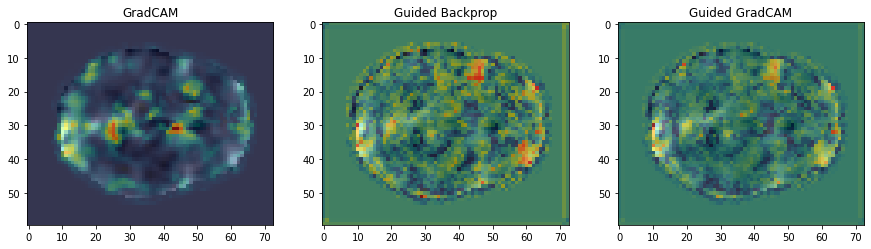

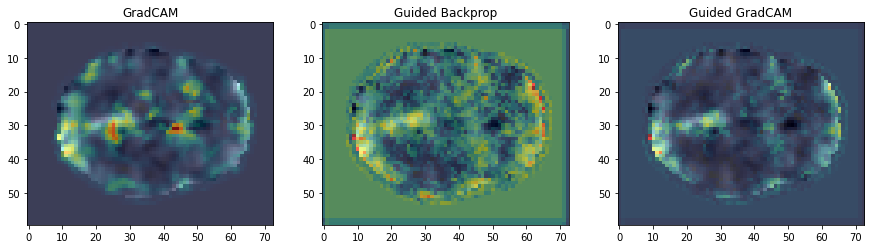

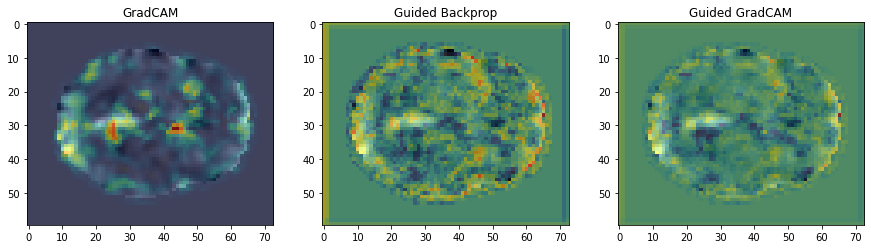

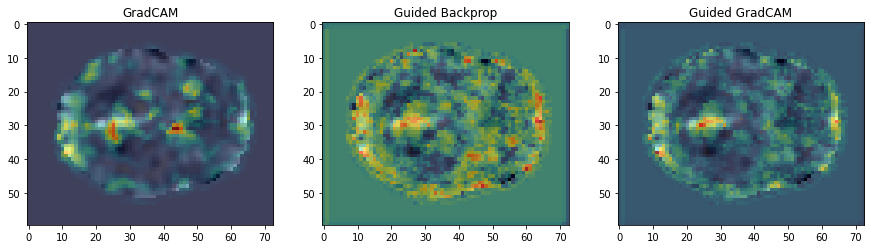

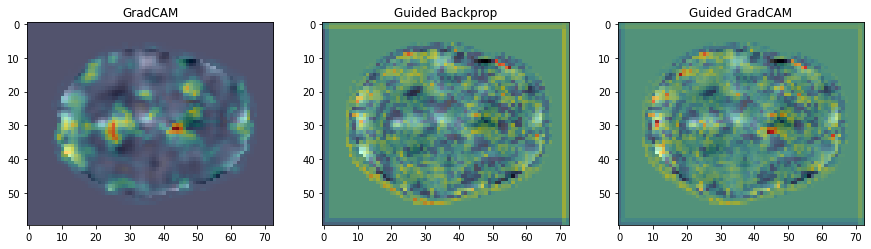

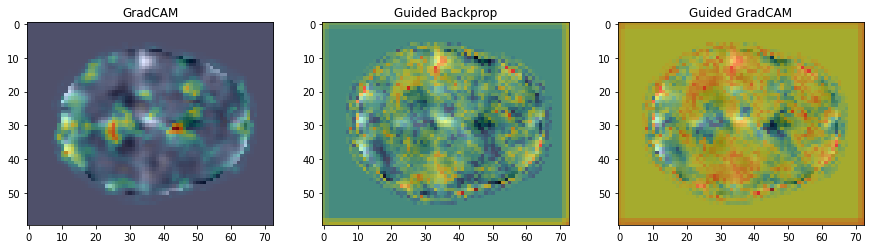

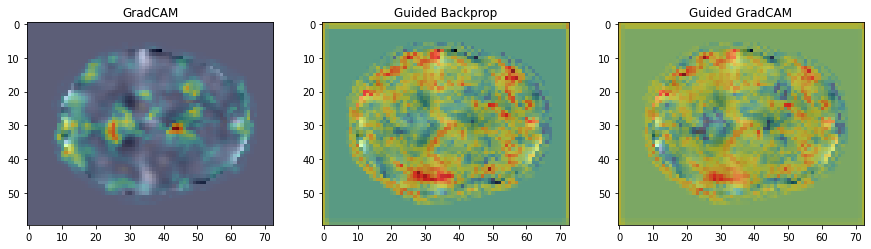

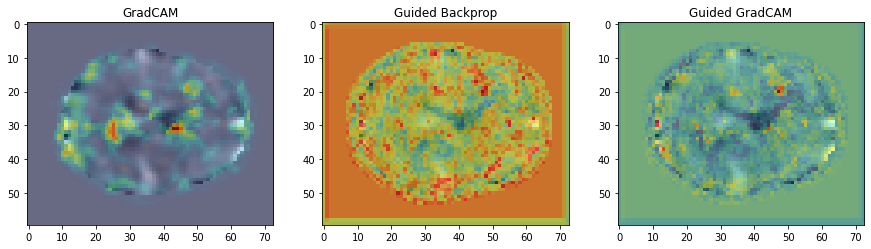

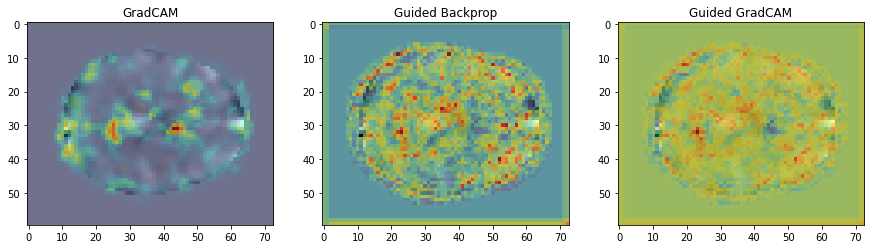

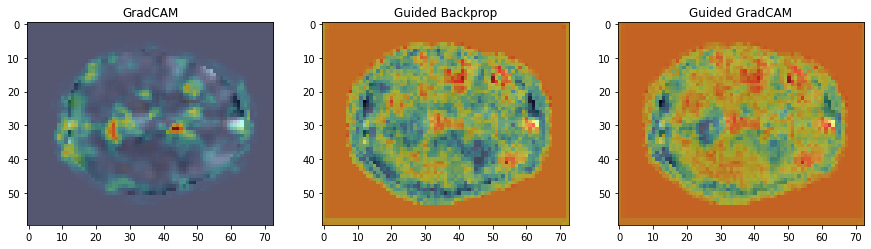

In [17]:
gradcam, guided_bp, guided_gradcam = compute_saliency(model_load, guided_model, X_test[1], 
                           layer_name='conv2d_1',cls=-1, visualize=True)

preprocessed_input (1, 60, 73, 60)
Model prediction:
	1	(0)	with probability 1.000
Explanation for '[1]'


/home/laura/.conda/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


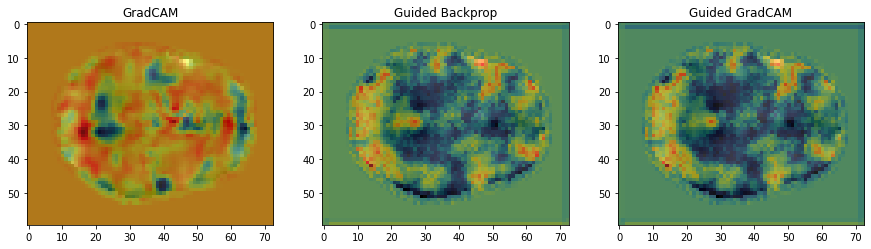

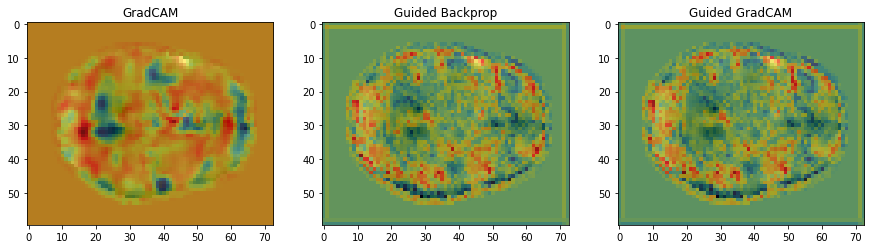

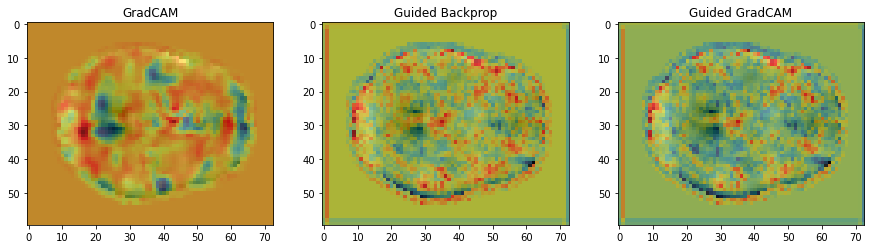

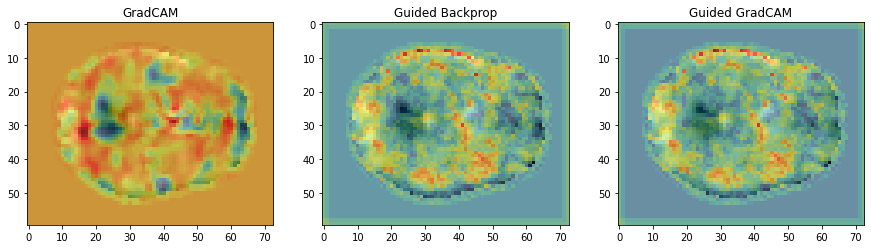

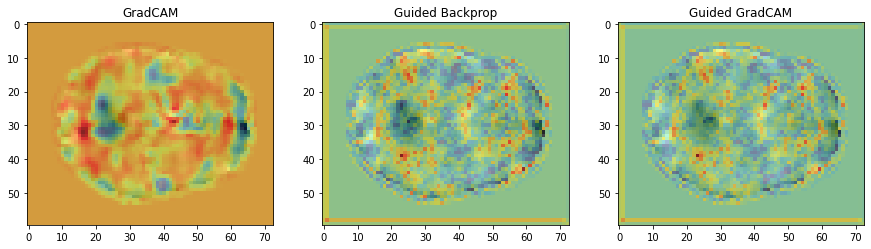

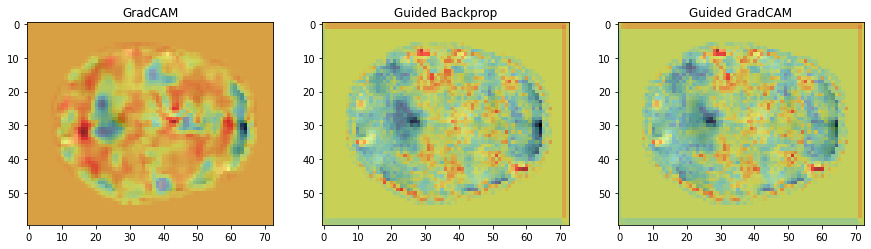

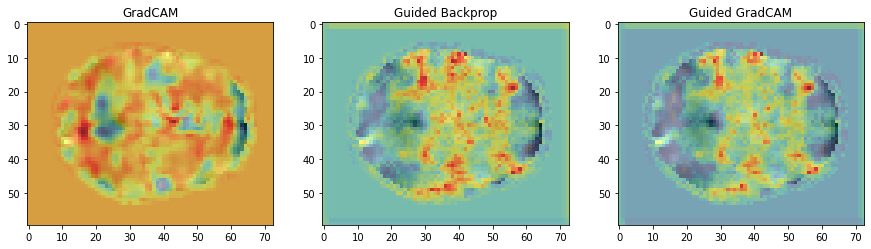

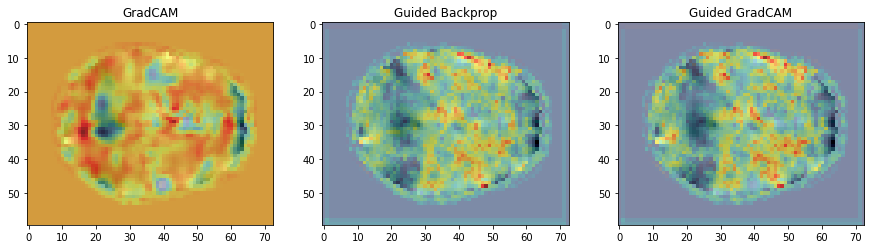

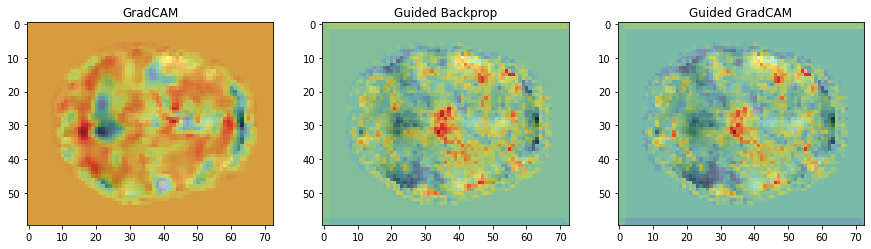

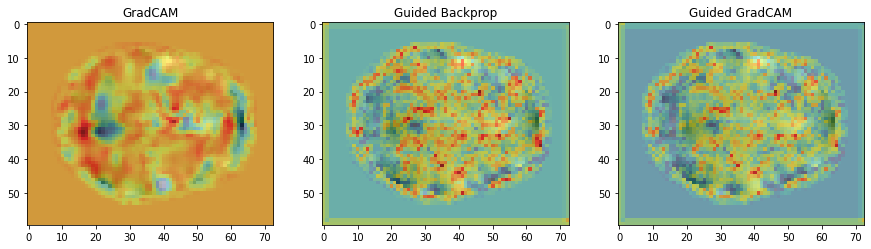

In [33]:
gradcam_d, guided_bpd, guided_gradcam_d = compute_saliency(model_load, guided_model, X_test[1], 
                                              layer_name='conv2d_1',cls=-1, visualize=True)

preprocessed_input (1, 60, 73, 60)
Model prediction:
	0	(1)	with probability 0.000
Explanation for '[0]'


/home/laura/.conda/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


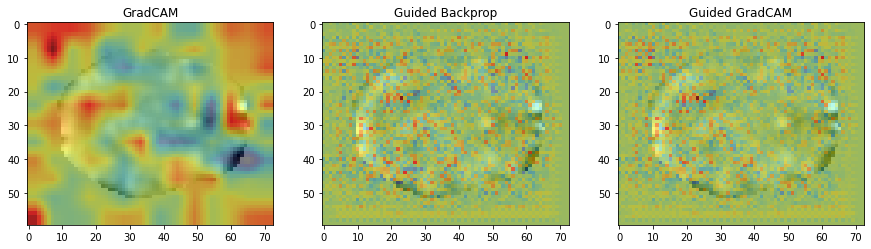

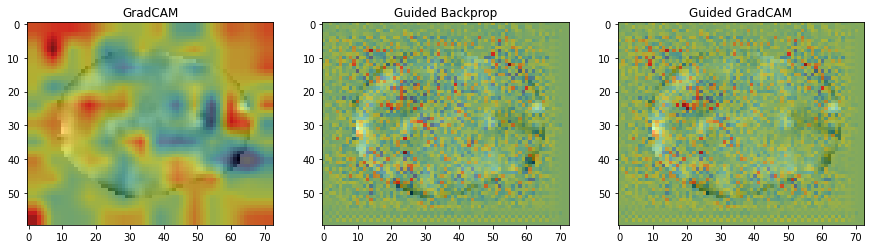

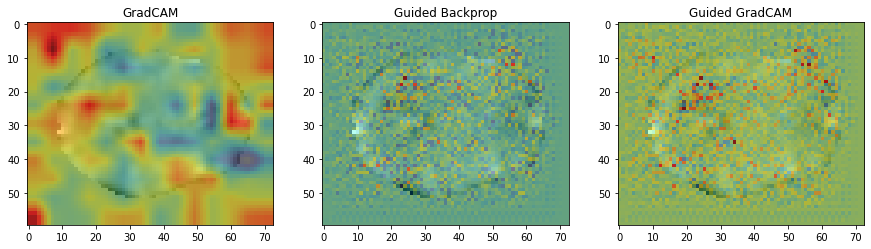

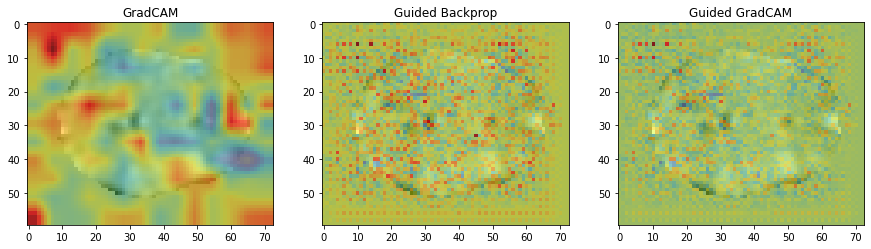

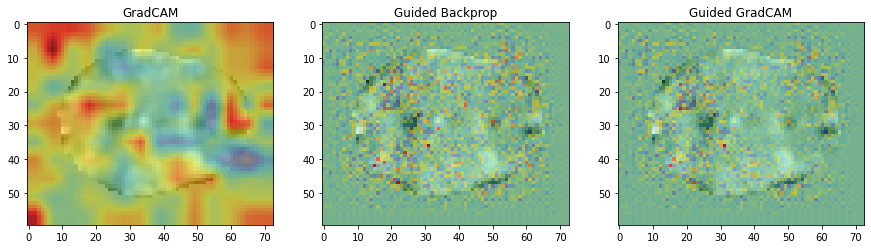

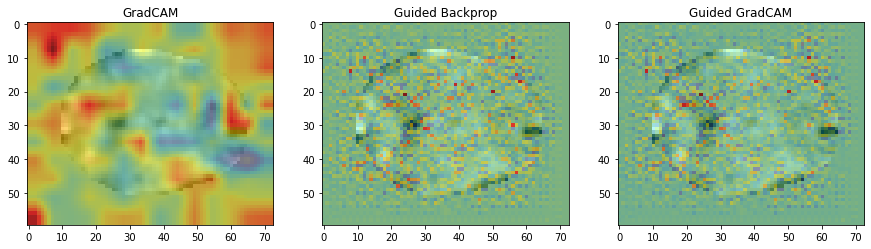

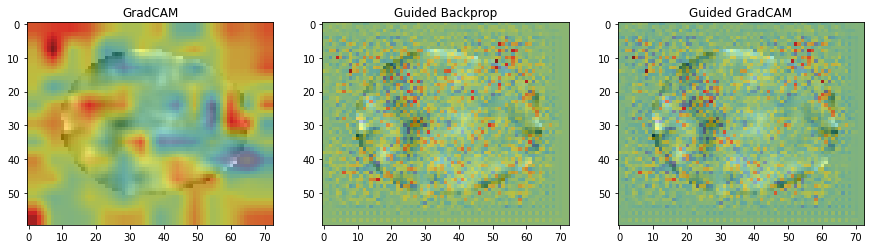

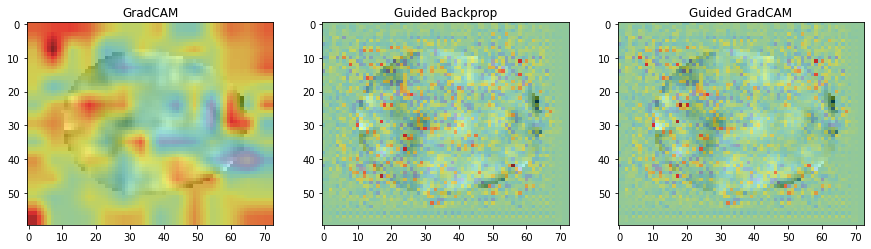

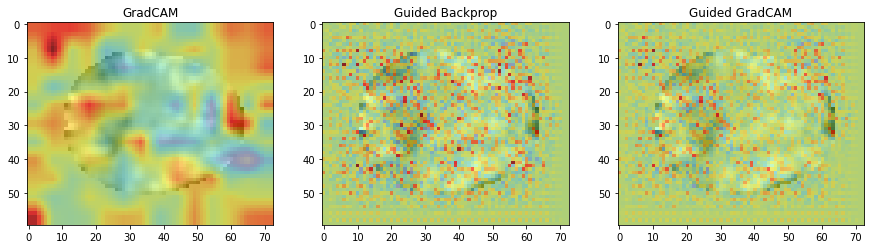

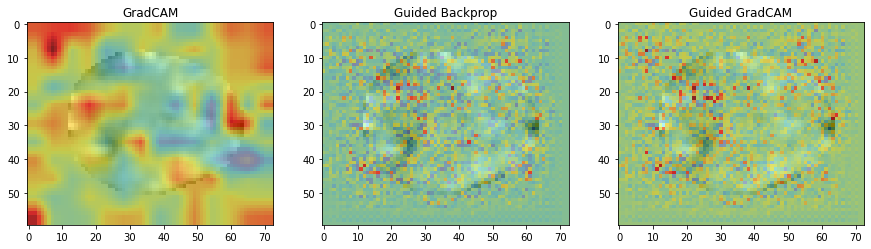

In [36]:
gradcam_c, guided_bpc, guided_gradcam_c = compute_saliency(model_load, guided_model, X_test[10], 
                           layer_name='conv2d_3',cls=-1, visualize=True)

preprocessed_input (1, 60, 73, 60)
Model prediction:
	0	(1)	with probability 0.000
Explanation for '[0]'


/home/laura/.conda/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


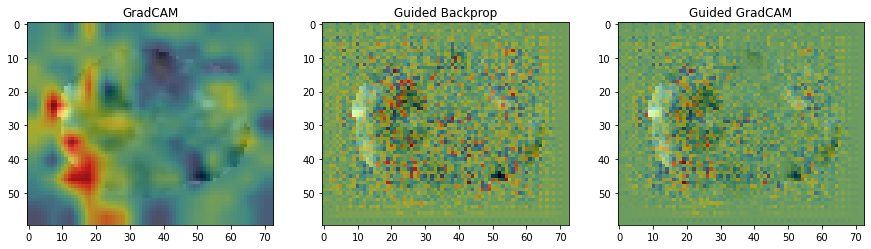

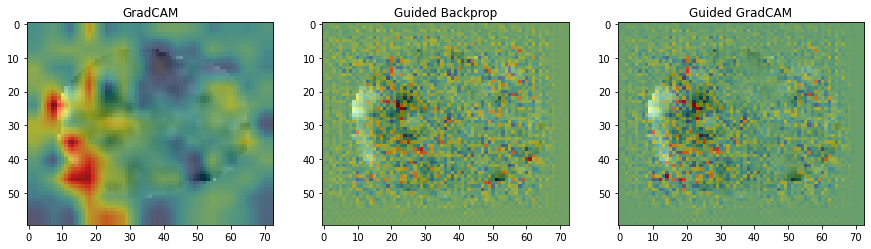

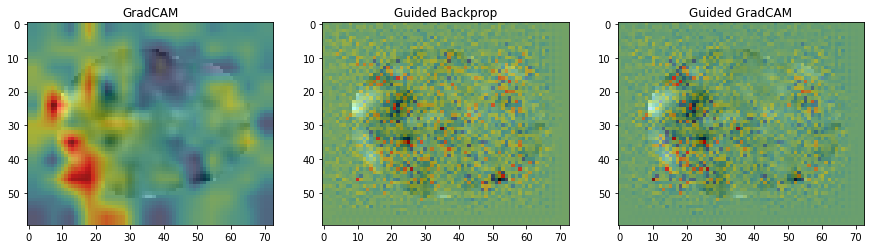

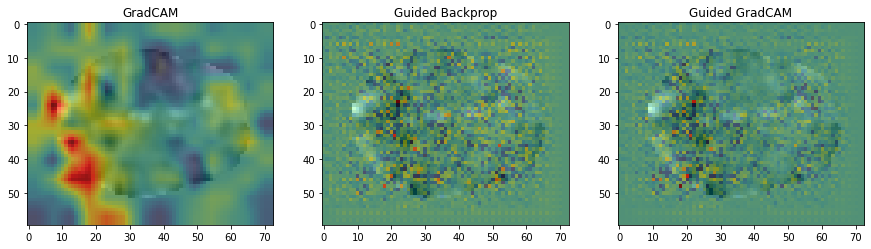

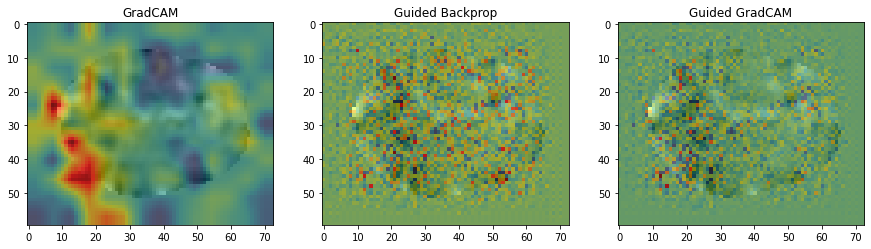

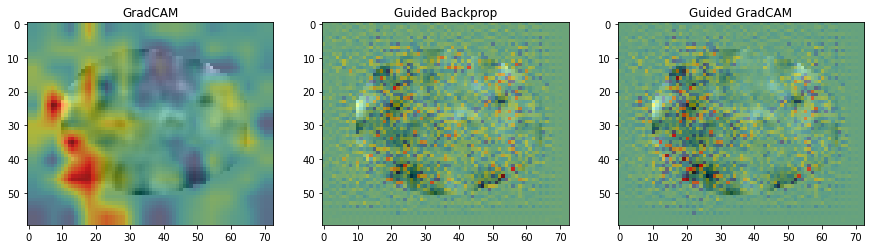

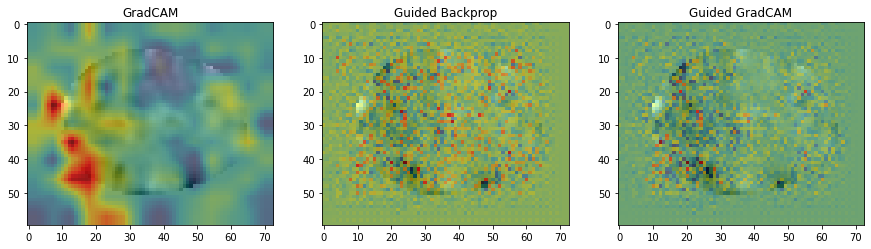

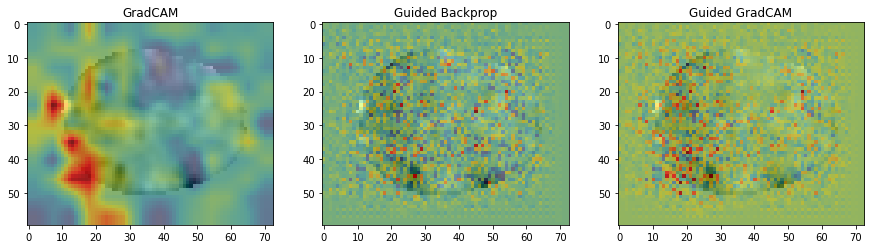

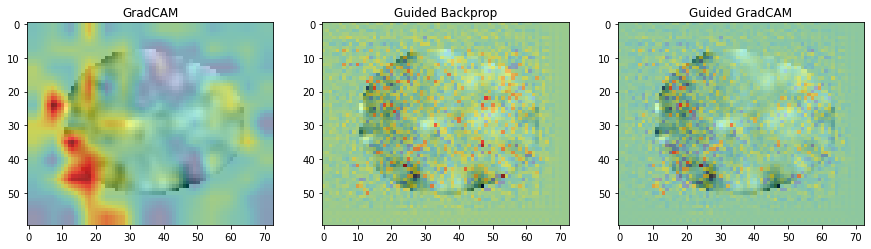

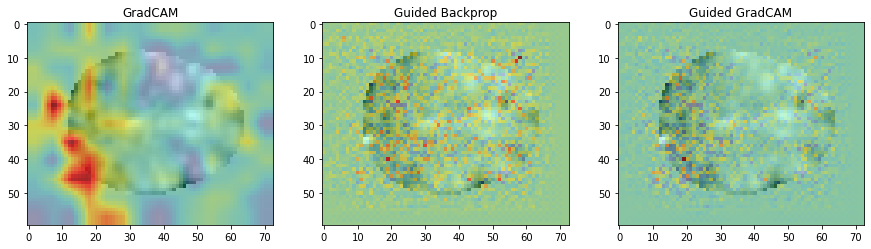

In [39]:
gradcam_c1, guided_bpc1, guided_gradcam_c1 = compute_saliency(model_load, guided_model, X_test[9], 
                                            layer_name='conv2d_3',cls=-1, visualize=True)